### 策略名稱：VaR 反彈進場策略（VaR Reversal Strategy）[更新時間：2025-06-09]

#### 策略背景

在市場極度恐慌時，股價常出現超跌現象，隨後伴隨短期反彈。本策略即以此為出發點，透過統計風險指標「VaR（Value at Risk）」辨識市場異常下跌日，進行逆勢操作。

---

#### 策略邏輯

本策略專門設計用於 00631L（台股兩倍槓桿 ETF），操作邏輯如下：

1. **進場條件**：
   - 若某日的真實日報酬（`Real_Ret`）低於過去歷史的 1% VaR（極端負報酬門檻），視為市場過度恐慌。
   - 此時全倉進場買入 00631L，等待價格反彈。

2. **出場條件**：
   - 若當前價格自進場以來反彈超過「VaR 跌幅」（即回到下跌前價位），則視為反彈完成。
   - 此時全數出場，實現短期獲利。

---

#### 策略細節設定

- **資產標的**：00631L（元大台灣50正2）
- **VaR 計算基礎**：以 `Real_Ret` 計算 1% VaR
- **交易週期**：每日盤後判斷一次
- **資金配置**：單筆滿倉進出，無加碼或分批
- **風控設計**：僅在極端下跌日操作，避免頻繁交易

---

#### 策略特色

- 利用**統計尾部風險**作為進場依據，具備量化標準。
- 採用**反向思維**：在市場情緒最悲觀時進場，專注於短線技術性反彈。
- 透過 VaR 反向推估出場點，提供明確且具風險控制的獲利機會。

---

#### 未來擴充建議

- 加入 CVaR（Conditional VaR）作為進階觸發條件。
- 評估搭配 RSI 或布林通道進一步強化進場過濾。
- 嘗試應用於不同標的（如美股 SQQQ、TECL 等槓桿 ETF）。

---

> 策略實證期間為 2020-01-01 至 2025-03-10，初始資金為 NT$1,000,000，結果由自製回測模組進行模擬。


In [1]:
import Backtest_model
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import copy
import matplotlib.ticker as ticker
import statsmodels.api as sm
import matplotlib.ticker as mtick
from Backtest_model import logic_para

In [28]:
Row_data = pd.read_csv(f'clean_backtest_data.csv')
data_use = Row_data.copy()
data_use['mdate'] = pd.to_datetime(data_use['mdate'])
data_use = data_use.rename(columns={
    'mdate': 'Date',
    'ROI': 'Ret',
    'coid': 'Symbol',
    'Close': 'ori_Close'
})

data_use['Close'] = data_use['ori_Close'] * data_use['Adjust_Factor']
data_use['Symbol'] = data_use['Symbol'].astype(str)
data_use = data_use.sort_values('Date')

data_use1 = data_use[data_use['Symbol'] == '0050']
data_use1['Real_Ret'] = data_use1['Close'].pct_change().fillna(0)
data_use1

/var/folders/st/lxg2kchn65x5y9ldzc2d4qgh0000gn/T/ipykernel_68903/3794962413.py:1: DtypeWarning: Columns (1) have mixed types. Specify dtype option on import or set low_memory=False.
  Row_data = pd.read_csv(f'clean_backtest_data.csv')
/var/folders/st/lxg2kchn65x5y9ldzc2d4qgh0000gn/T/ipykernel_68903/3794962413.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_use1['Real_Ret'] = data_use1['Close'].pct_change().fillna(0)


,Unnamed: 0,Symbol,Date,Open,High,Adjust_Factor,Ret,Volume_1000_Shares,Market,Low,ori_Close,Close,Real_Ret
75970,75970,0050,2006-01-02,50.75,50.80,0.510858,-1.3659,4920.0,TWSE,50.35,50.55,25.823872,0.000000
77056,77056,0050,2006-01-03,50.45,51.50,0.510858,1.7804,5229.0,TWSE,50.40,51.45,26.283644,0.017804
78161,78161,0050,2006-01-04,51.95,52.10,0.510858,0.4859,9562.0,TWSE,51.50,51.70,26.411359,0.004859
79253,79253,0050,2006-01-05,52.05,52.60,0.510858,1.4507,8176.0,TWSE,52.05,52.45,26.794502,0.014507
80360,80360,0050,2006-01-06,52.45,52.80,0.510858,-0.2860,5867.0,TWSE,52.30,52.30,26.717873,-0.002860
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7083031,7083031,0050,2025-05-23,182.75,182.80,1.000000,-0.4130,7223.0,TWSE,180.20,180.85,180.850000,-0.004130
7083798,7083798,0050,2025-05-26,180.65,181.50,1.000000,-0.1106,14332.0,TWSE,180.30,180.65,180.650000,-0.001106
7084582,7084582,0050,2025-05-27,180.65,180.65,1.000000,-0.8857,13688.0,TWSE,178.00,179.05,179.050000,-0.008857
7085345,7085345,0050,2025-05-28,180.90,181.35,1.000000,0.1676,8703.0,TWSE,178.30,179.35,179.350000,0.001676


VAR ：-4.56799


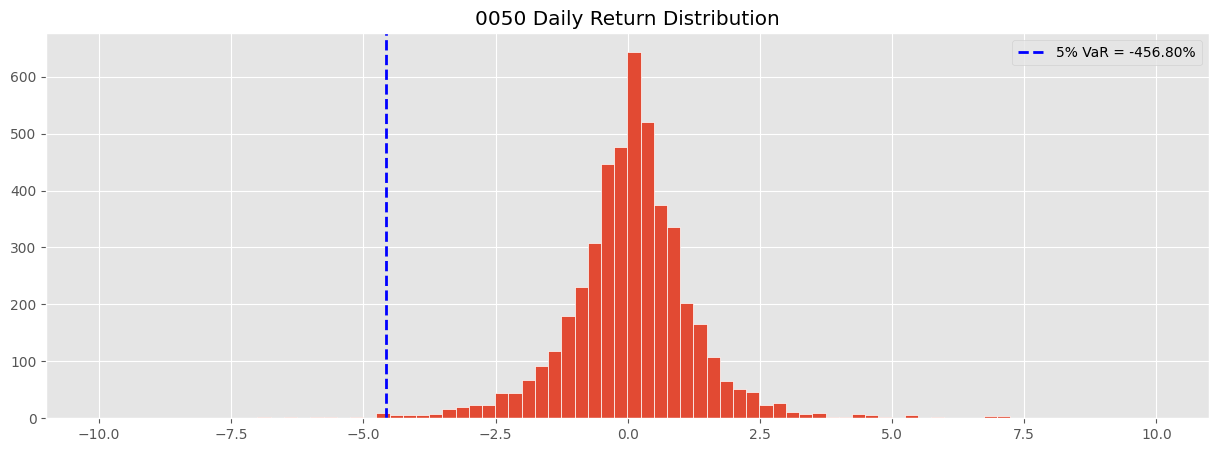

In [29]:
var_5 = np.percentile(data_use1['Ret'], 0.5)
print(f"VAR ：{var_5}")

plt.style.use('ggplot')
plt.figure(figsize = (15, 5))
plt.hist(data_use1['Ret'], bins = 80, edgecolor = 'white')
plt.axvline(var_5, color='blue', linestyle='--', linewidth=2, label=f'5% VaR = {var_5:.2%}')
plt.title(f'0050 Daily Return Distribution')
plt.legend()
plt.show()

In [41]:
import numpy as np

# 計算 5% VaR
var_5 = np.percentile(data_use1['Real_Ret'], 0.5)

# 找出報酬率小於 VaR 的次數
count_below_var = (data_use1['Real_Ret'] < var_5).sum()

print(f"報酬率小於 0.5% VaR（{var_5}）的次數為：{count_below_var} 次")


報酬率小於 0.5% VaR（-0.045679952371999885）的次數為：24 次


In [55]:
para = logic_para()
para.score = 0
para.state = False

para.price = 0
para.record = 0


bull = []
bear = []
ind_start = []
ind_end = []


var_05 = np.percentile(data_use1['Real_Ret'], 0.5)
var_1 = np.percentile(data_use1['Real_Ret'], 1)


def logic(idx, date, portfolio, performance, market, factor_data, para):

    today_data = factor_data[factor_data['Date'] == pd.to_datetime(date)]
    para.score = today_data['Real_Ret'].iloc[0]
    para.price = today_data['Close'].iloc[0]


    if para.record == 0:
        para.record = para.price

    if para.score <= var_1  and para.state == False:
        Backtest_model.order(portfolio=portfolio, symbol='00631L', target=1.0, Market=market)
        para.state = True
        para.record = para.price
        print(f'{date}：以{para.price:.2f}進場')


    if para.price >= para.record * (1 - var_1) and para.state == True:
        Backtest_model.order(portfolio=portfolio, symbol='00631L', target=0.0, Market=market)
        para.state = False
        print(f'{date}獲取報酬：{((para.price/para.record) -1):.4f}')




result = Backtest_model.run_backtest(data = data_use,
                       strategy_function = logic, 
                       start_date = '2020-01-01', 
                       end_date = '2025-03-10', 
                       Benchmark_code = 'IR0001',
                       factor_data = data_use1, 
                       initial_cash = 1_000_000,
                       logic_para=para)

# 呼叫函數 compute_stat() 計算回測績效數據
result.compute_stat()

-------------------------------------------------- Strategy Logic Start --------------------------------------------------
2020-01-30：以77.02進場
2020-02-12獲取報酬：0.0381
2020-03-12：以70.89進場
2020-04-30獲取報酬：0.0408
2021-05-11：以118.35進場
2021-06-11獲取報酬：0.0364
2022-07-01：以101.51進場
2022-07-18獲取報酬：0.0400
2022-10-11：以93.08進場
2022-11-09獲取報酬：0.0377
2024-04-19：以148.09進場
2024-04-24獲取報酬：0.0361
2024-07-26：以176.56進場
2024-09-25獲取報酬：0.0489
2025-02-03：以192.70進場
-------------------------------------------------- Strategy Logic End --------------------------------------------------


,指標,數值
0,累積報酬率,0.7998
1,年化報酬率,0.1251
2,年化波動度,0.2300
3,夏普比率,0.5440
4,最大回撤,-0.3330
5,Calmar比率,0.3758
6,Alpha (年化),0.0142
7,Beta,0.7432
8,Benchmark 累積報酬率,1.2007
9,Benchmark 年化報酬率,0.1715


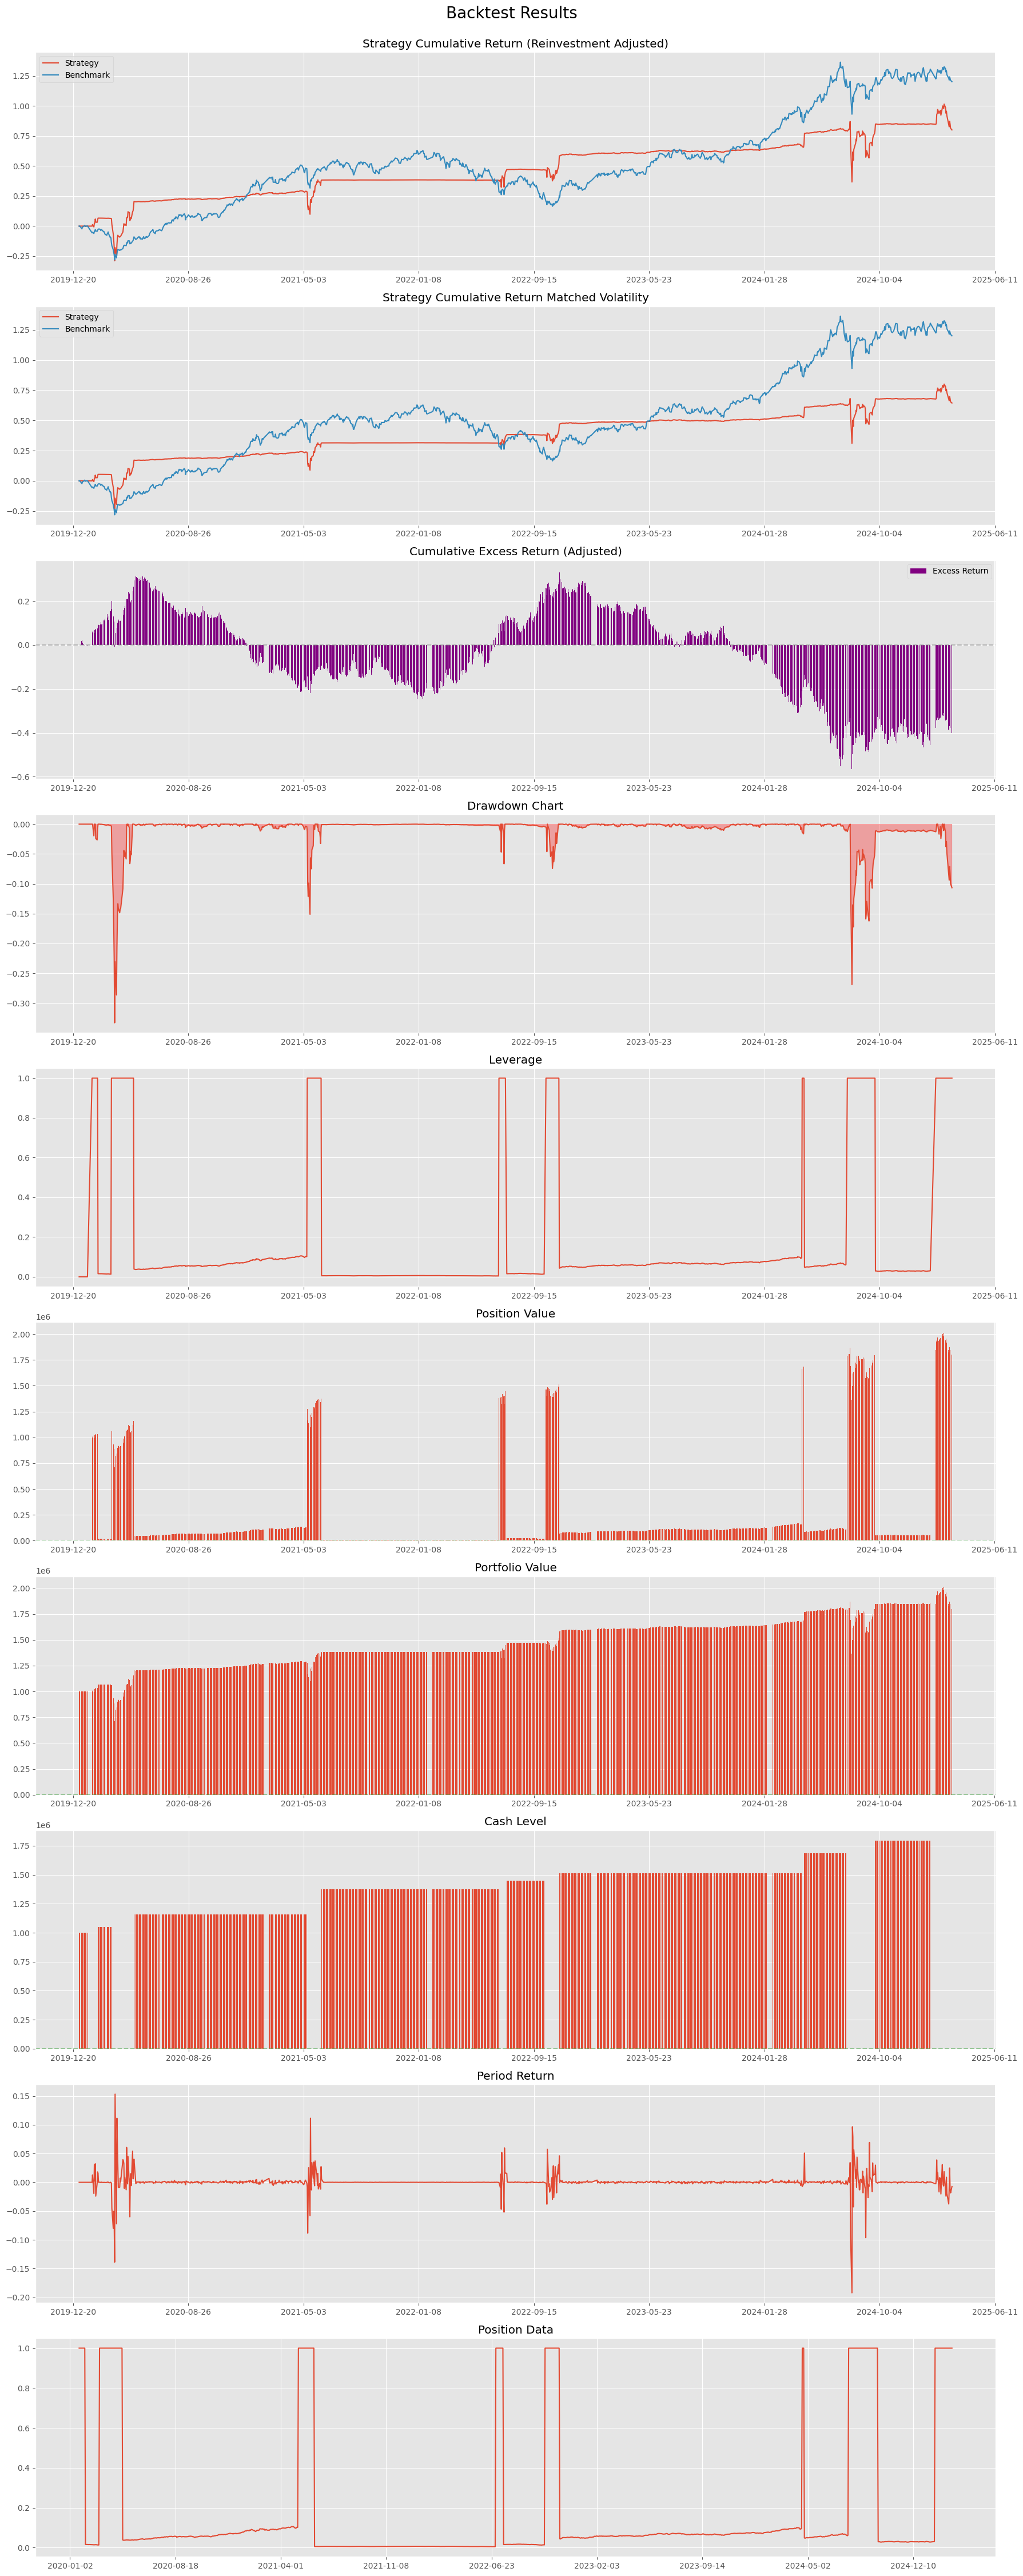

In [56]:
result.plot_performance() 